## Генерация изображений с помощью Stable Diffusion

В этом ноутбуке мы исследуем разные возможности по генерации изображений. Для начала, создадим директорию, куда мы будем складывать все результаты генерации.

In [1]:
import os
os.makedirs('output',exist_ok=True)

Также установим полезные библиотеки:

In [72]:
%pip install -q shwarsutils diffusers


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [73]:
from shwars.utils import display_images

### Text to Image

Простейшая генерация - из текста в изображение. Можно загрузить готовую модель, и при необходимости поверх неё до-обученный стиль LoRA. В последнем случае не забывайте использовать специальный промпт.

In [2]:
import torch
from diffusers import DiffusionPipeline, AutoencoderKL

model_name = "./GRBX_LoRA"

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)
pipe.load_lora_weights(model_name)
_ = pipe.to("cuda")

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:106: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2025-03-14 15:51:27.133577: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-14 15:51:28.677485: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-14 15:51:34.466564: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Loading pipeline components...

Генерируем изображение:

100%|██████████| 30/30 [00:09<00:00,  3.22it/s]


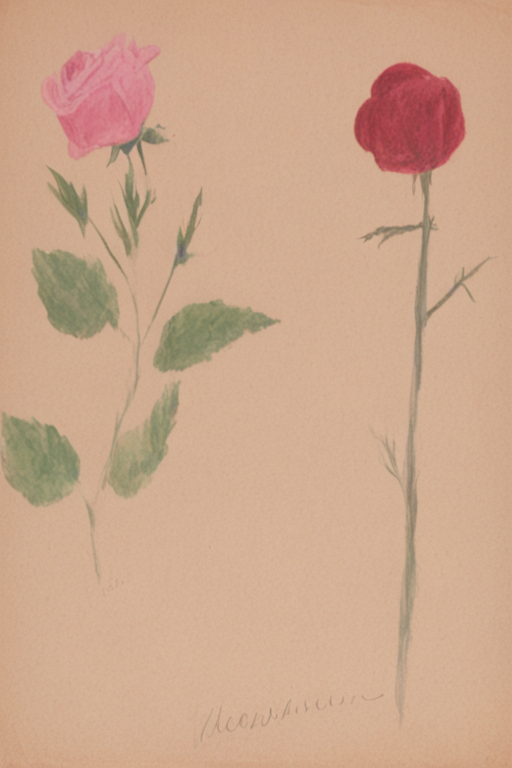

In [45]:
prompt = "drawing of a rose, gerbarium in GRBX style"

res = pipe(
    prompt,
    num_inference_steps=30,
    height=768,
    width=512
).images[0]

res

Сохраняем его, если понравилось:

In [39]:
res.save(f"output/res.jpg")

> Если хватает памяти GPU, то можно генерировать сразу по несколько изображений (2-3), указывая параметр `num_generated_images`

Можем сгенерировать изображение, сохраняя все промежуточные шаги генерации:

In [ ]:
from PIL import Image
import numpy as np

prompt = "drawing of a maple leaf on white background, gerbarium in GRBX style"

# Number of inference steps
num_inference_steps = 50

def save_intermediate_images(step, timestep, latents):
    """
    Callback function to save intermediate images during the denoising process.
    """
    with torch.no_grad():
        image = pipe.vae.decode(latents / pipe.vae.config.scaling_factor).sample
        image = (image / 2 + 0.5).clamp(0, 1)  # Normalize to [0,1]
        image = image.permute(0, 2, 3, 1).cpu().numpy()[0]  # Convert to numpy
        img = Image.fromarray((image*255).astype(np.uint8))
        img.save(f"output/step_{step:03d}.png")

# Generate image while capturing intermediate frames
pipe(
    prompt,
    num_inference_steps=num_inference_steps,
    callback=save_intermediate_images,
    callback_steps=1  # Capture every step
)

100%|██████████| 50/50 [01:38<00:00,  1.97s/it]


StableDiffusionXLPipelineOutput(images=[<PIL.Image.Image image mode=RGB size=1024x1024 at 0x7FACECACB700>])

Можно смонтировать все шаги диффузии вместе в небольшое видео:

In [ ]:
!ffmpeg -r 10 -i output/step_%03d.png -vcodec libx264 diffusion_process.mp4

## Inpainting

Inpainting - это режим для дорисовки фрагментов изображения. Возьмём за образец икону из Ферапонтового монастыря:

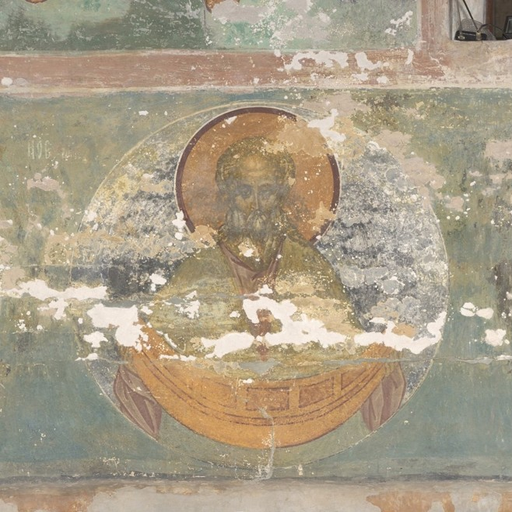

In [56]:
img = Image.open('images/restoration.jpg')
img = img.crop((0,0,img.width//2-10,img.height)).resize((512,512),Image.Resampling.LANCZOS)
img

Извлечём маску, взяв все пиксели изображения, которые ярче некоторого порога, а также применив фильтр размытия (Blur) для сглаживания мелких зон.

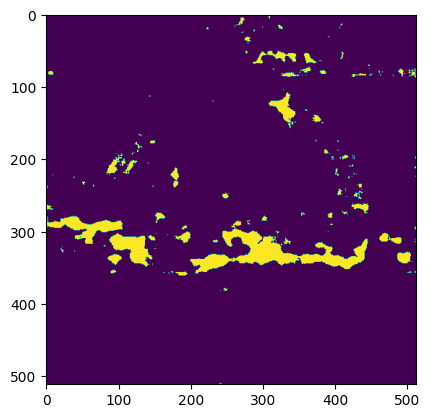

In [75]:
import matplotlib.pyplot as plt
from PIL import ImageFilter

mask = np.array(img.convert("L").filter(ImageFilter.BLUR))>200
mask = mask.astype(np.uint8)
plt.imshow(mask)

Загружаем модель для Inpainting:

In [ ]:
from diffusers import AutoPipelineForInpainting
pipe = None
pipe = AutoPipelineForInpainting.from_pretrained(
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
    torch_dtype=torch.float16,
    use_safetensors=True,
)
_ = pipe.to("cuda")

Fetching 18 files:   6%|▌         | 1/18 [00:09<02:49, 10.00s/it]


Генерируем результирующее изображение:

100%|██████████| 49/49 [00:37<00:00,  1.30it/s]


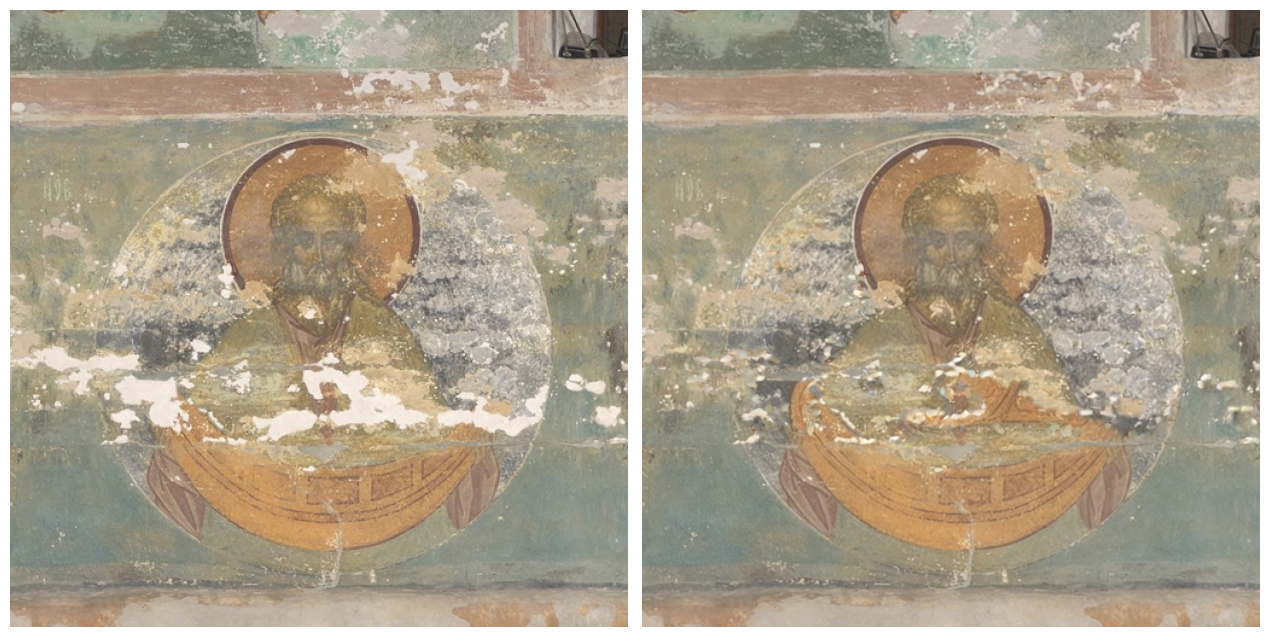

In [76]:
res = pipe(prompt="old restored russian orthodox icon",
           image=img,
           mask_image=mask).images[0]
display_images([img,res])

Конечно, результат будет лучше, если мы вручную нарисуем маску, которая будет частично перекрывать фрагменты изображения, чтобы белых пустот не оставалось.

## Outpainting

OutPainting - это режим, при котором мы дорисовываем внешнюю часть изображения.

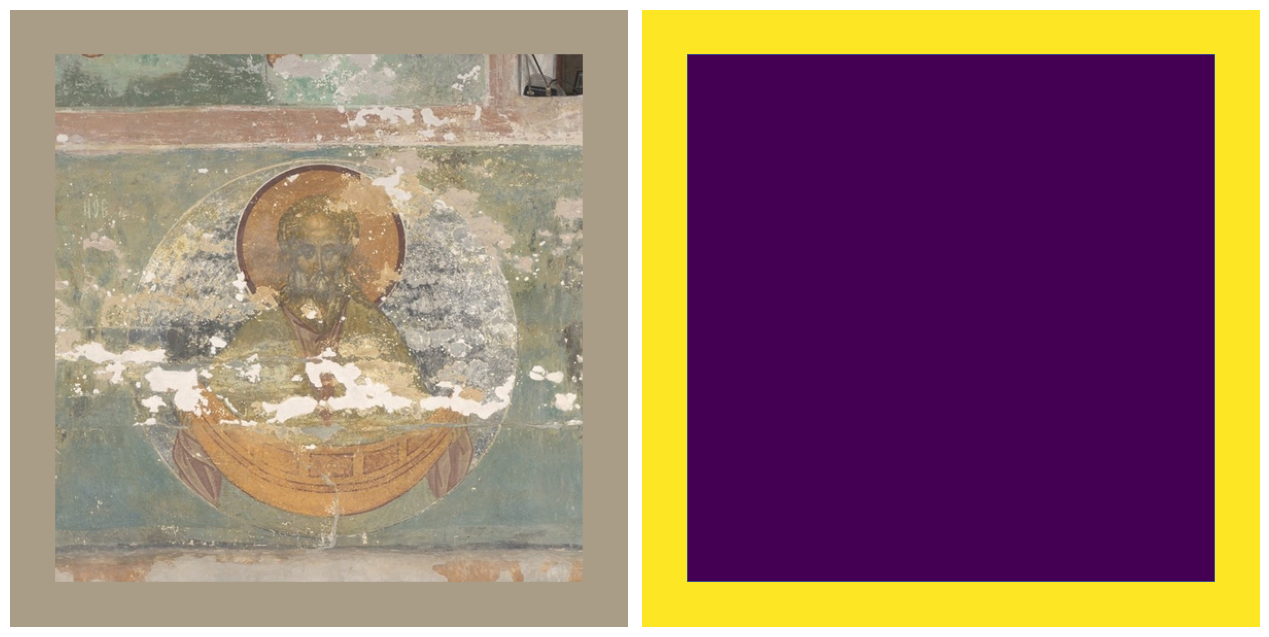

In [120]:
mean_color = tuple(np.array(img).mean(axis=(0,1)).astype(np.uint8))
new_image = Image.new("RGB", (600, 600), mean_color)
new_image.paste(img, (44, 44))
new_mask = np.zeros((600,600),dtype=np.uint8)
new_mask[0:44,:] = 1
new_mask[:,0:44] = 1
new_mask[556:,:] = 1
new_mask[:,556:] = 1
display_images([new_image,new_mask])

100%|██████████| 49/49 [00:14<00:00,  3.27it/s]


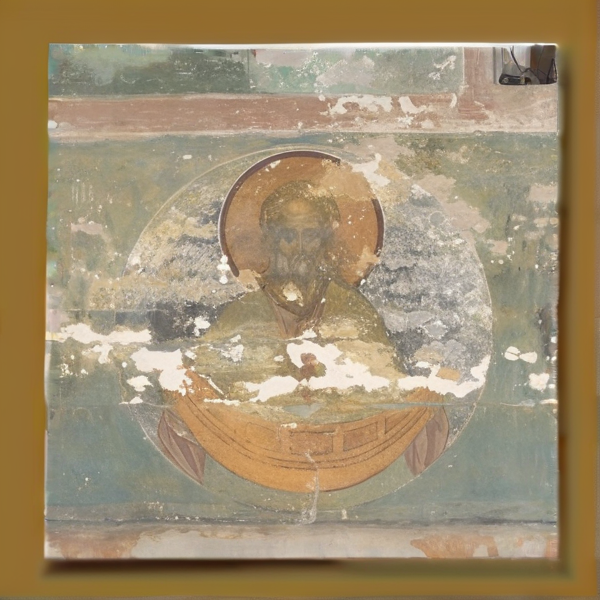

In [121]:
res = pipe(prompt="old restored russian orthodox icon set",
           image=new_image,
           mask_image=new_mask,width=600,height=600).images[0]
res

In [92]:
res.size

(1024, 512)